In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score

# Preprocessing

In [ ]:
df_total_train = pd.read_csv('/content/Xmd_train_scaled.csv')
df_total_test = pd.read_csv('/content/Xmd_test_scaled.csv')

# merging
data = pd.concat([df_total_train, df_total_test], axis=0, ignore_index=True)

In [ ]:
# Encoding
encoder = OrdinalEncoder()

encoder.fit(data[['sex']])
data['sex']= encoder.transform(data[['sex']])
encoder.fit(data[['main.disorder']])
data['main.disorder']= encoder.transform(data[['main.disorder']])

In [ ]:
# using all features
X_total = data.drop('main.disorder', axis=1)
y_total = data['main.disorder']

In [ ]:
# using psd only
X_psd = data.loc[:, ~data.columns.str.startswith('COH.')]
y_psd = X_psd['main.disorder']
X_psd = X_psd.drop('main.disorder', axis=1)

In [ ]:
#data sampling
from imblearn.over_sampling import SMOTE
smote_total = SMOTE(sampling_strategy ='all', random_state = 42)
X_total_resampled, y_total_resampled = smote_total.fit_resample(X_total, y_total)

smote_psd = SMOTE(sampling_strategy ='all', random_state = 42)
X_psd_resampled, y_psd_resampled = smote_psd.fit_resample(X_psd, y_psd)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_total = StandardScaler()
scaler_total.fit(X_total_resampled)
X_total_scaled= scaler_total.transform(X_total_resampled)

scaler_psd = StandardScaler()
scaler_psd.fit(X_psd_resampled)
X_psd_scaled= scaler_psd.transform(X_psd_resampled)

In [ ]:
# Splitting
X_total_train, X_total_test, y_total_train, y_total_test = train_test_split(X_total_scaled, y_total_resampled , test_size =.2, stratify = y_total_resampled)
X_psd_train, X_psd_test, y_psd_train, y_psd_test = train_test_split(X_psd_scaled, y_psd_resampled , test_size =.2, stratify = y_psd_resampled)

# All features

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
# More efficient configuration
total_lgbm = lgb.LGBMClassifier(
    min_data_in_leaf=20,
    num_leaves=15,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=200,
    feature_fraction=0.7,
    verbosity=1,
    random_state=42
)

# With more aggressive early stopping
total_lgbm.fit(
    X_total_train, y_total_train,
    eval_set=[(X_total_test, y_total_test)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),  # Stops after 5 non-improving rounds
    ]
)
# Make predictions
test_data_prediction = total_lgbm.predict(X_total_test)

# Classification report
cr = classification_report(y_total_test, test_data_prediction)
print(cr)

# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_total_test, test_data_prediction),
    "Precision (Weighted)": precision_score(y_total_test, test_data_prediction, average='weighted'),
    "Recall (Weighted)": recall_score(y_total_test, test_data_prediction, average='weighted'),
    "F1-Score (Weighted)": f1_score(y_total_test, test_data_prediction, average='weighted'),
    "ROC AUC (OvR)": roc_auc_score(y_total_test, total_lgbm.predict_proba(X_total_test), multi_class='ovr')
}

print(pd.DataFrame.from_dict(metrics, orient='index', columns=["Value"]))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 291598
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 1144
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Curren

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### visualization

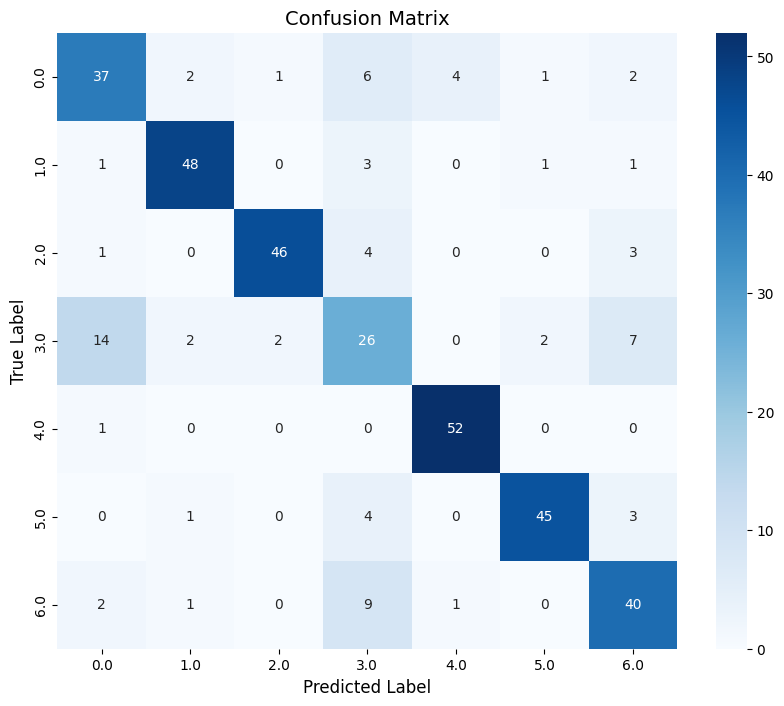

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_total_test, test_data_prediction)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=total_lgbm.classes_,
            yticklabels=total_lgbm.classes_)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


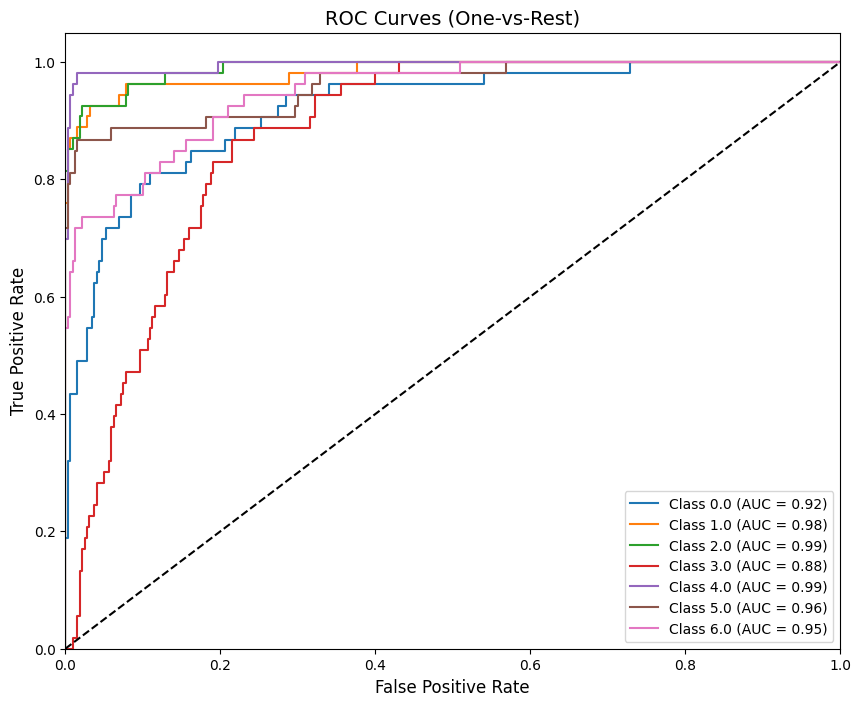

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_total_test, classes=total_lgbm.classes_)
y_score = total_lgbm.predict_proba(X_total_test)

# Compute ROC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, class_label in enumerate(total_lgbm.classes_):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(10, 8))
for class_label in total_lgbm.classes_:
    plt.plot(fpr[class_label], tpr[class_label],
             label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (One-vs-Rest)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.show()

# PSD only

In [ ]:
# More efficient configuration
total_lgbm = lgb.LGBMClassifier(
    min_data_in_leaf=20,
    num_leaves=15,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=200,
    feature_fraction=0.7,
    verbosity=1,
    random_state=42
)

# With more aggressive early stopping
total_lgbm.fit(
    X_psd_train, y_psd_train,
    eval_set=[(X_psd_test, y_psd_test)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),  # Stops after 5 non-improving rounds
    ]
)
# Make predictions
test_data_prediction = total_lgbm.predict(X_psd_test)

# Classification report
cr = classification_report(y_psd_test, test_data_prediction)
print(cr)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29969
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 118
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Best hyperparameters
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Define the base model with your current best parameters
base_model = lgb.LGBMClassifier(
    min_data_in_leaf=20,
    feature_fraction=0.7,
    verbosity=1,
    random_state=42,
    objective='multiclass'
)

# Limited hyperparameter grid
param_grid = {
    'num_leaves': [15, 31],          # Controls tree complexity
    'max_depth': [5, 8, -1],         # -1 = no limit
    'learning_rate': [0.05, 0.1],     # Step size shrinkage
    'n_estimators': [100, 200]        # Number of trees
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,                             # 3-fold cross-validation
    scoring='accuracy',               # Primary metric
    n_jobs=-1,                       # Use all CPU cores
    verbose=2                        # Print progress
)

# Run grid search
grid_search.fit(X_psd_train, y_psd_train)

# Best results
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_psd_test)
print(classification_report(y_psd_test, test_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29969
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 118
[LightGBM] [Info] Start training from score -1.944568
[LightGBM] [Info] Start training from score -1.944568
[LightGBM] [Info] Start training from score -1.944568
[LightGBM] [Info] Start training from score -1.944568
[L

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


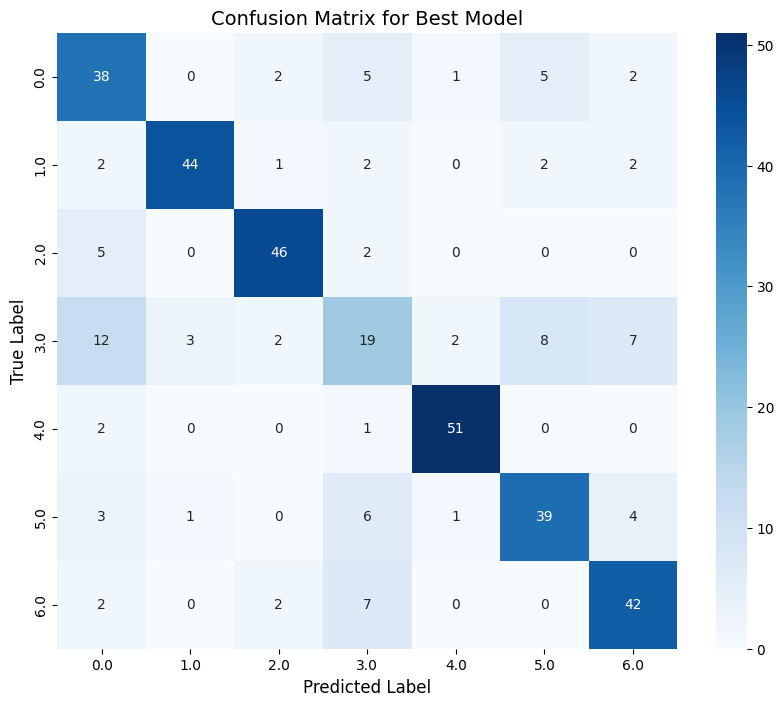

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions from best model
y_pred = best_model.predict(X_psd_test)

# Create confusion matrix
cm = confusion_matrix(y_psd_test, y_pred)

# Plot with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix for Best Model', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


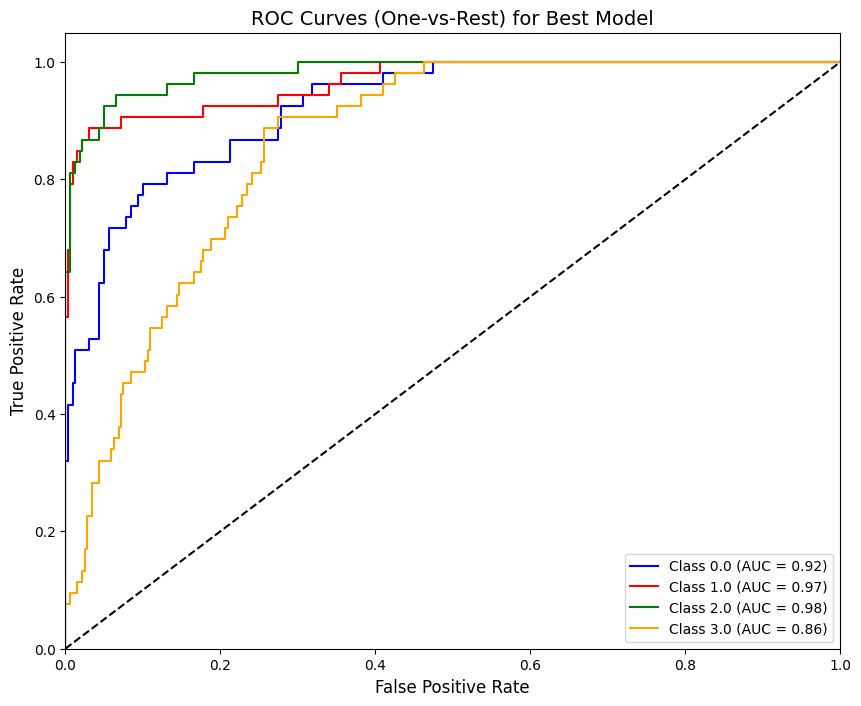

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output
y_test_bin = label_binarize(y_psd_test, classes=best_model.classes_)
y_score = best_model.predict_proba(X_psd_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(best_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Adjust for number of classes
for i, color in zip(range(len(best_model.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='Class {0} (AUC = {1:0.2f})'
             ''.format(best_model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves (One-vs-Rest) for Best Model', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print("Classification Report:")
print(classification_report(y_psd_test, y_pred))

# Print accuracy
print(f"Test Accuracy: {accuracy_score(y_psd_test, y_pred):.4f}")

# Print AUC scores
print("\nAUC Scores (One-vs-Rest):")
for i in range(len(best_model.classes_)):
    print(f"Class {best_model.classes_[i]}: {roc_auc[i]:.4f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.72      0.65        53
         1.0       0.92      0.83      0.87        53
         2.0       0.87      0.87      0.87        53
         3.0       0.45      0.36      0.40        53
         4.0       0.93      0.94      0.94        54
         5.0       0.72      0.72      0.72        54
         6.0       0.74      0.79      0.76        53

    accuracy                           0.75       373
   macro avg       0.75      0.75      0.74       373
weighted avg       0.75      0.75      0.74       373

Test Accuracy: 0.7480

AUC Scores (One-vs-Rest):
Class 0.0: 0.9245
Class 1.0: 0.9666
Class 2.0: 0.9827
Class 3.0: 0.8626
Class 4.0: 0.9940
Class 5.0: 0.9346
Class 6.0: 0.9528
